In [364]:
# Importing liberaries
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler, RobustScaler
import seaborn as sns
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from tabulate import tabulate
from pandas import read_csv
from numpy import mean
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_model import ARMA
import warnings
from catboost import CatBoostRegressor
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',FutureWarning)
%matplotlib inline

In [365]:
# reading dataset
# This data set is collected using web scraping methods from https://bitinfocharts.com till 18th may 2021
df=pd.read_csv("BTC_code/BTC_DATA.csv")
df['Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d')
df.set_index("Date", inplace = True)

In [366]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4389 entries, 2010-07-18 to 2022-07-23
Columns: 737 entries, Unnamed: 0 to price90rocUSD
dtypes: float64(690), int64(47)
memory usage: 24.7 MB


In [367]:
df.head()

,Unnamed: 0,priceUSD,transactions,size,sentbyaddress,difficulty,hashrate,mining_profitability,sentinusdUSD,transactionfeesUSD,...,price3rsiUSD,price7rsiUSD,price14rsiUSD,price30rsiUSD,price90rsiUSD,price3rocUSD,price7rocUSD,price14rocUSD,price30rocUSD,price90rocUSD
Date,,,,,,,,,,,,,,,,,,,,,
2010-07-18,0,0.0726,248,765.285,424,181.543,1.554461e+09,401834.0,2612.0,0.000243,...,0.000,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0
2010-07-19,1,0.0859,354,756.040,553,181.543,1.551287e+09,481473.0,4047.0,0.000022,...,0.000,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0
2010-07-20,2,0.0783,413,984.707,632,181.543,1.640430e+09,431831.0,2341.0,0.000000,...,82.751,0.0,0.0,0.0,0.0,58.099,0.0,0.0,0.0,0.0
2010-07-21,3,0.0767,256,542.483,440,181.543,1.723493e+09,460783.0,2122.0,0.000000,...,78.603,0.0,0.0,0.0,0.0,5.652,0.0,0.0,0.0,0.0
2010-07-22,4,0.0649,221,491.903,412,181.543,1.705481e+09,334641.0,2570.0,0.000000,...,49.814,0.0,0.0,0.0,0.0,-24.455,0.0,0.0,0.0,0.0


In [368]:
# checking data set contains null values
df.isnull().values.any()

False

In [369]:
missed = pd.DataFrame()
missed['column'] = df.columns

missed['percent'] = [round(100* df[col].isnull().sum() / len(df), 2) for col in df.columns]

missed = missed.sort_values('percent',ascending=False)
print(missed)

                        column  percent
0                   Unnamed: 0      0.0
495   transactionvalue30stdUSD      0.0
486   transactionvalue90trxUSD      0.0
487    transactionvalue3momUSD      0.0
488    transactionvalue7momUSD      0.0
..                         ...      ...
248   mining_profitability7ema      0.0
249  mining_profitability14ema      0.0
250  mining_profitability30ema      0.0
251  mining_profitability90ema      0.0
736              price90rocUSD      0.0

[737 rows x 2 columns]


In [370]:
def mem_usage(pandas_obj):
    if isinstance(pandas_obj,pd.DataFrame):
        usage_b = pandas_obj.memory_usage(deep=True).sum()
    else: # we assume if not a df it's a series
        usage_b = pandas_obj.memory_usage(deep=True)
    usage_mb = usage_b / 1024 ** 2 # convert bytes to megabytes
    return "{:03.2f} MB".format(usage_mb)
print(mem_usage(df))

24.71 MB


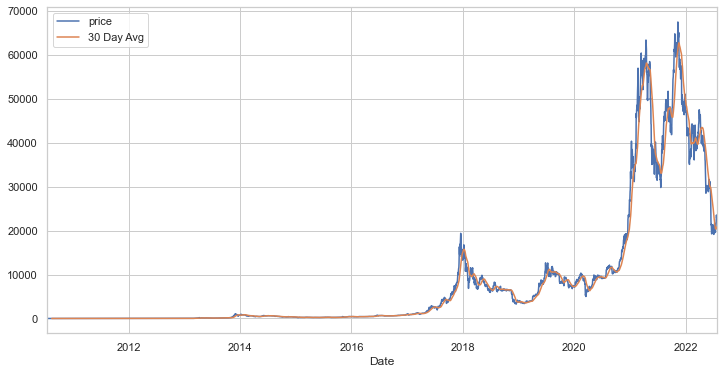

In [371]:
# Visulising the price of BTC 30 day average basis
sns.set()
sns.set_style('whitegrid')
df['priceUSD'].plot(figsize=(12,6),label='price')
df['priceUSD'].rolling(window=30).mean().plot(label='30 Day Avg')# Plotting the 
plt.legend()
plt.show()

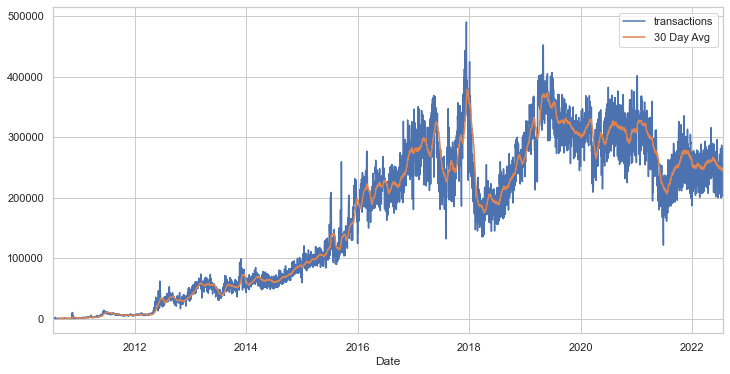

In [372]:
# ploting the no of tractions on 30 average basis
sns.set()
sns.set_style('whitegrid')
df['transactions'].plot(figsize=(12,6),label='transactions')
df['transactions'].rolling(window=30).mean().plot(label='30 Day Avg')# Plotting the 
plt.legend()
plt.show()

In [373]:
# statistcs 
from tabulate import tabulate
info = [[col, df[col].count(), df[col].max(), df[col].min(),df[col].mean()] for col in df.columns]
print(tabulate(info, headers = ['Feature', 'Count', 'Max', 'Min','Mean'], tablefmt = 'orgtbl'))

| Feature                        |   Count |              Max |               Min |             Mean |
|--------------------------------+---------+------------------+-------------------+------------------|
| Unnamed: 0                     |    4389 |   4388           |       0           |   2194           |
| priceUSD                       |    4389 |  67547           |       0.053       |   8197.99        |
| transactions                   |    4389 | 490459           |      92           | 170977           |
| size                           |    4389 | 998092           |     322.952       | 510365           |
| sentbyaddress                  |    4389 | 730199           |     226           | 260076           |
| difficulty                     |    4389 |      3.12511e+13 |     181.543       |      5.64131e+12 |
| hashrate                       |    4389 |      2.53047e+20 |       1.55129e+09 |      4.09371e+19 |
| mining_profitability           |    4389 | 481473           |       0.0

In [374]:
df1=df.reset_index(drop=True)
X=df1.drop('priceUSD', 1)
X

C:\Users\ahcha\AppData\Local\Temp\ipykernel_22300\4227636930.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X=df1.drop('priceUSD', 1)


,Unnamed: 0,transactions,size,sentbyaddress,difficulty,hashrate,mining_profitability,sentinusdUSD,transactionfeesUSD,median_transaction_feeUSD,...,price3rsiUSD,price7rsiUSD,price14rsiUSD,price30rsiUSD,price90rsiUSD,price3rocUSD,price7rocUSD,price14rocUSD,price30rocUSD,price90rocUSD
0,0,248,765.285,424,1.815430e+02,1.554461e+09,401834.0000,2.612000e+03,0.000243,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,1,354,756.040,553,1.815430e+02,1.551287e+09,481473.0000,4.047000e+03,0.000022,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,2,413,984.707,632,1.815430e+02,1.640430e+09,431831.0000,2.341000e+03,0.000000,0.000,...,82.751,0.000,0.000,0.000,0.000,58.099,0.000,0.000,0.000,0.000
3,3,256,542.483,440,1.815430e+02,1.723493e+09,460783.0000,2.122000e+03,0.000000,0.000,...,78.603,0.000,0.000,0.000,0.000,5.652,0.000,0.000,0.000,0.000
4,4,221,491.903,412,1.815430e+02,1.705481e+09,334641.0000,2.570000e+03,0.000000,0.000,...,49.814,0.000,0.000,0.000,0.000,-24.455,0.000,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4384,4384,279812,746068.000,502989,2.915280e+13,1.891411e+20,0.1060,5.415818e+10,2.147000,0.839,...,93.897,75.464,58.546,44.905,42.126,7.894,13.943,12.592,16.868,-45.701
4385,4385,260069,717017.000,457913,2.915280e+13,1.924968e+20,0.0996,4.309965e+10,2.324000,1.027,...,96.938,81.982,64.268,48.147,43.052,11.050,20.222,16.851,16.143,-43.491
4386,4386,273837,719470.000,465780,2.882714e+13,1.910321e+20,0.1070,5.569455e+10,2.026000,0.936,...,66.958,69.145,59.013,46.453,42.639,5.182,13.698,10.446,9.218,-42.873
4387,4387,263144,661528.000,414074,2.769257e+13,1.889912e+20,0.1040,5.839661e+10,1.913000,0.848,...,71.358,70.905,60.175,47.091,42.823,2.806,11.375,6.403,13.958,-41.676


In [375]:
y=df1[["priceUSD"]]
y

,priceUSD
0,0.0726
1,0.0859
2,0.0783
3,0.0767
4,0.0649
...,...
4384,22514.0000
4385,23568.0000
4386,22936.0000
4387,23145.0000


# Dropping those features which is highly correlated each other.

In [376]:
# Create correlation matrix
corr_matrix = X.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find index of feature columns with correlation greater than 0.75
to_drop = [column for column in upper.columns if any(upper[column] > 0.75)]

In [377]:
to_drop

['transactions',
 'size',
 'sentbyaddress',
 'difficulty',
 'hashrate',
 'median_transaction_feeUSD',
 'transactionvalueUSD',
 'mediantransactionvalueUSD',
 'activeaddresses',
 'top100cap',
 'fee_to_rewardUSD',
 'transactions3sma',
 'transactions7sma',
 'transactions14sma',
 'transactions30sma',
 'transactions90sma',
 'transactions3ema',
 'transactions7ema',
 'transactions14ema',
 'transactions30ema',
 'transactions90ema',
 'transactions3wma',
 'transactions7wma',
 'transactions14wma',
 'transactions30wma',
 'transactions90wma',
 'transactions7std',
 'transactions14std',
 'transactions30std',
 'transactions90std',
 'transactions3var',
 'transactions7var',
 'transactions14var',
 'transactions30var',
 'transactions90var',
 'transactions7rsi',
 'transactions14rsi',
 'transactions30rsi',
 'transactions90rsi',
 'transactions14roc',
 'transactions30roc',
 'transactions90roc',
 'size3sma',
 'size7sma',
 'size14sma',
 'size30sma',
 'size90sma',
 'size3ema',
 'size7ema',
 'size14ema',
 'size30e

In [378]:
# Drop features 
X.drop(X[to_drop], axis=1,inplace=True)

In [379]:
X.shape

(4389, 171)

In [380]:
X_columns=list(X.columns)
y_columns=["priceUSD"]

In [381]:
correlation_result={}
for i in range(len(X_columns)):
    correlation = X[X_columns[i]].corr(y["priceUSD"])
    correlation_result[X_columns[i]]=correlation
correlation_result=sorted(correlation_result.items(), key = lambda kv:(kv[1], kv[0]),reverse=True)

In [382]:
correlation_result

[('Unnamed: 0', 0.7084648486887481),
 ('sentinusdUSD', 0.6665208298432648),
 ('transactionfeesUSD', 0.5147705328242796),
 ('difficulty14std', 0.5100706342676862),
 ('activeaddresses7std', 0.49824779961848525),
 ('mining_profitability90trx', 0.44230608452381764),
 ('activeaddresses3std', 0.42905260779406584),
 ('transactions3std', 0.37827889163295925),
 ('difficulty90mom', 0.37463216019095513),
 ('difficulty7std', 0.3493478209208217),
 ('hashrate90mom', 0.34706563902246484),
 ('price90momUSD', 0.2800309717986583),
 ('difficulty30mom', 0.2528566249684441),
 ('transactionvalue90momUSD', 0.2446085789071257),
 ('fee_to_reward3stdUSD', 0.24102177597627875),
 ('mining_profitability30trx', 0.23736581254793182),
 ('difficulty3std', 0.2190145450747022),
 ('size3std', 0.21759423781513348),
 ('hashrate30mom', 0.18316176889445374),
 ('confirmationtime', 0.17369029914054593),
 ('sentinusd90momUSD', 0.1726187457208404),
 ('difficulty14mom', 0.1629628124047951),
 ('price30momUSD', 0.13335963908259021)

In [383]:
len(correlation_result)

171

In [384]:
temp=[]
for i in correlation_result:
    temp.append(i[0])
X_train2=X[temp]
X_train2

,Unnamed: 0,sentinusdUSD,transactionfeesUSD,difficulty14std,activeaddresses7std,mining_profitability90trx,activeaddresses3std,transactions3std,difficulty90mom,difficulty7std,...,transactionfees90trxUSD,sentbyaddress14trx,hashrate3trx,transactions30trx,size90mom,difficulty3trx,mining_profitability90sma,sentbyaddress30trx,top100cap90std,transactions90trx
0,0,2.612000e+03,0.000243,1.079720e+02,3836.000,0.000,806.213,409.788,1.737230e+02,1.275940e+02,...,0.000,13.249,14.367,9.590,461.406,46.606,0.000,4.719,3.855,1.942
1,1,4.047000e+03,0.000022,1.247640e+02,3872.000,0.000,139.870,106.596,1.737230e+02,1.338740e+02,...,0.000,11.086,4.890,9.526,480.796,30.397,0.000,4.892,3.807,2.078
2,2,2.341000e+03,0.000000,1.360760e+02,3973.000,0.000,57.743,136.532,1.735570e+02,1.295820e+02,...,0.000,9.201,1.182,9.253,758.534,19.000,0.000,4.951,3.760,2.200
3,3,2.122000e+03,0.000000,1.430260e+02,910.003,0.000,133.889,129.502,1.700790e+02,1.157030e+02,...,0.000,7.508,0.390,8.818,343.257,11.819,0.000,4.904,3.707,2.306
4,4,2.570000e+03,0.000000,1.462080e+02,652.409,0.000,256.262,166.984,1.700790e+02,8.340300e+01,...,0.000,6.020,0.151,8.290,265.170,7.335,0.000,4.779,3.649,2.395
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4384,4384,5.415818e+10,2.147000,2.148773e+11,194475.000,-0.432,216592.000,63833.000,9.268707e+11,3.852714e+06,...,-0.263,-0.066,-0.437,-0.084,125038.000,-0.004,0.119,-0.015,0.253,-0.013
4385,4385,4.309965e+10,2.324000,1.369287e+09,186298.000,-0.434,114188.000,26401.000,9.268707e+11,3.852714e+06,...,-0.261,-0.088,-0.418,-0.081,118507.000,-0.002,0.118,-0.019,0.253,-0.013
4386,4386,5.569455e+10,2.026000,1.677421e+11,178152.000,-0.436,94111.000,16533.000,6.012077e+11,2.279166e+11,...,-0.258,-0.109,-0.384,-0.074,37932.000,-0.141,0.117,-0.023,0.252,-0.013
4387,4387,5.839661e+10,1.913000,7.579135e+11,169728.000,-0.438,94359.000,11801.000,-5.333602e+11,1.009299e+12,...,-0.256,-0.154,-0.450,-0.067,133542.000,-0.698,0.116,-0.031,0.252,-0.014


In [385]:
top_20_features=[]
for i in range(20):
    top_20_features.append(correlation_result[i][0])

# selecting top 20 features

In [386]:
top_20_features
X_train=X[top_20_features]

In [387]:
#refhttps://stackoverflow.com/questions/39409866/correlation-heatmap
# calculate the correlation matrix
corr = X_train.corr()
cmap = cmap=sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())

C:\Users\ahcha\AppData\Local\Temp\ipykernel_22300\3649181598.py:18: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap, axis=1)\


,Unnamed: 0,sentinusdUSD,transactionfeesUSD,difficulty14std,activeaddresses7std,mining_profitability90trx,activeaddresses3std,transactions3std,difficulty90mom,difficulty7std,hashrate90mom,price90momUSD,difficulty30mom,transactionvalue90momUSD,fee_to_reward3stdUSD,mining_profitability30trx,difficulty3std,size3std,hashrate30mom,confirmationtime
Unnamed: 0,1.00,0.51,0.37,0.51,0.71,0.32,0.60,0.64,0.37,0.34,0.32,0.06,0.22,0.08,0.39,0.24,0.21,0.48,0.14,0.30
sentinusdUSD,0.51,1.00,0.32,0.34,0.36,0.27,0.30,0.26,0.27,0.23,0.26,0.06,0.25,0.35,0.14,0.16,0.16,0.17,0.15,0.12
transactionfeesUSD,0.37,0.32,1.00,0.25,0.39,0.48,0.33,0.33,0.18,0.18,0.09,0.47,0.12,0.18,0.54,0.35,0.11,-0.11,-0.03,0.15
difficulty14std,0.51,0.34,0.25,1.00,0.33,0.26,0.28,0.27,0.07,0.63,0.01,-0.09,-0.03,0.07,0.20,0.11,0.26,0.18,-0.02,0.17
activeaddresses7std,0.71,0.36,0.39,0.33,1.00,0.35,0.74,0.58,0.29,0.24,0.24,0.16,0.17,0.09,0.43,0.24,0.14,0.30,0.10,0.22
mining_profitability90trx,0.32,0.27,0.48,0.26,0.35,1.00,0.29,0.33,0.17,0.18,0.16,0.30,0.13,0.15,0.37,0.45,0.11,-0.01,0.09,0.03
activeaddresses3std,0.60,0.30,0.33,0.28,0.74,0.29,1.00,0.64,0.25,0.20,0.22,0.14,0.14,0.08,0.38,0.20,0.14,0.37,0.08,0.18
transactions3std,0.64,0.26,0.33,0.27,0.58,0.33,0.64,1.00,0.21,0.19,0.20,0.14,0.13,0.09,0.46,0.27,0.14,0.42,0.10,0.20
difficulty90mom,0.37,0.27,0.18,0.07,0.29,0.17,0.25,0.21,1.00,0.06,0.74,0.21,0.59,0.03,0.12,0.02,0.03,0.17,0.22,0.11
difficulty7std,0.34,0.23,0.18,0.63,0.24,0.18,0.20,0.19,0.06,1.00,0.02,-0.03,-0.02,0.07,0.15,0.07,0.54,0.10,-0.02,0.11


In [388]:
X_train=df[top_20_features]
X_train.head()

,Unnamed: 0,sentinusdUSD,transactionfeesUSD,difficulty14std,activeaddresses7std,mining_profitability90trx,activeaddresses3std,transactions3std,difficulty90mom,difficulty7std,hashrate90mom,price90momUSD,difficulty30mom,transactionvalue90momUSD,fee_to_reward3stdUSD,mining_profitability30trx,difficulty3std,size3std,hashrate30mom,confirmationtime
Date,,,,,,,,,,,,,,,,,,,,
2010-07-18,0,2612.0,0.000243,107.972,3836.000,0.0,806.213,409.788,173.723,127.594,1.467781e+09,0.0,164.162,0.0,0.000,0.0,112.356,191.448,1.426285e+09,8.372
2010-07-19,1,4047.0,0.000022,124.764,3872.000,0.0,139.870,106.596,173.723,133.874,1.466614e+09,0.0,164.162,0.0,0.014,0.0,0.000,104.932,1.417005e+09,8.276
2010-07-20,2,2341.0,0.000000,136.076,3973.000,0.0,57.743,136.532,173.557,129.582,1.553496e+09,0.0,164.162,0.0,0.015,0.0,0.000,211.366,1.500528e+09,7.956
2010-07-21,3,2122.0,0.000000,143.026,910.003,0.0,133.889,129.502,170.079,115.703,1.613749e+09,0.0,164.162,0.0,0.001,0.0,0.000,361.145,1.571638e+09,6.957
2010-07-22,4,2570.0,0.000000,146.208,652.409,0.0,256.262,166.984,170.079,83.403,1.621318e+09,0.0,164.162,0.0,0.000,0.0,0.000,442.707,1.572259e+09,8.182


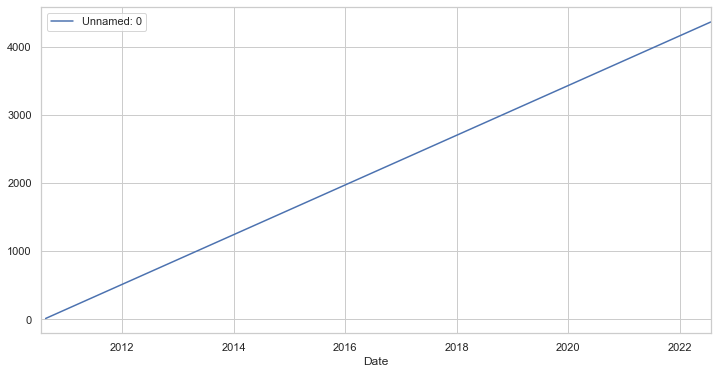

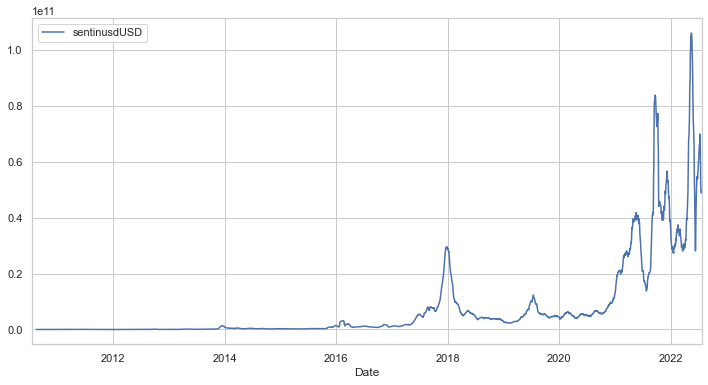

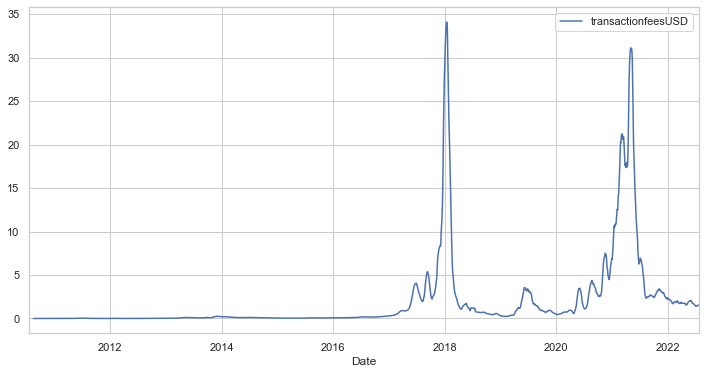

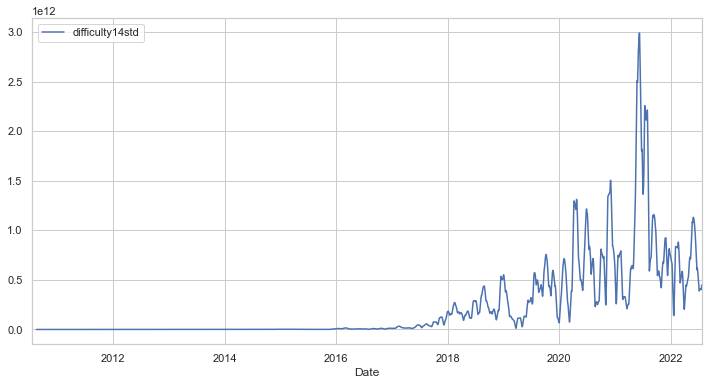

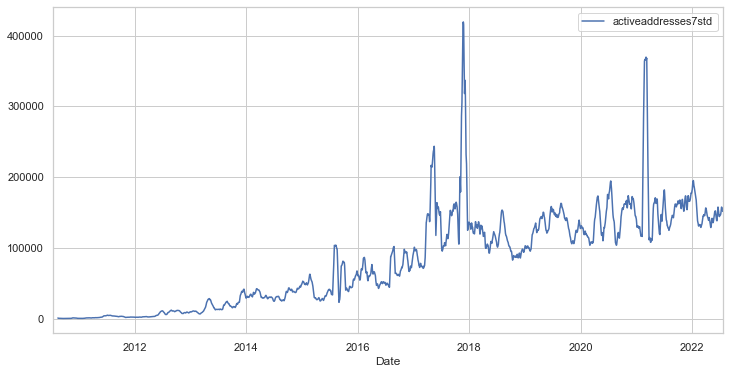

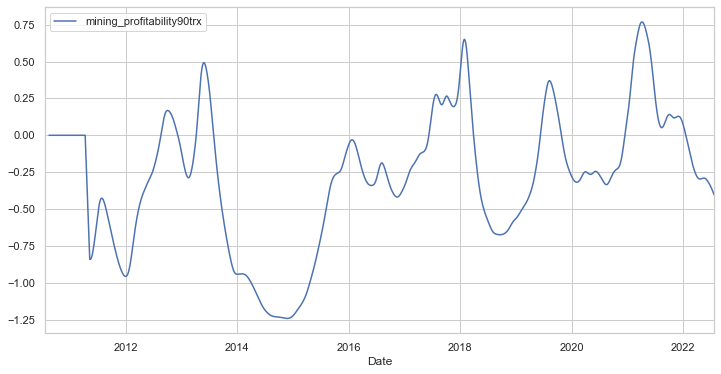

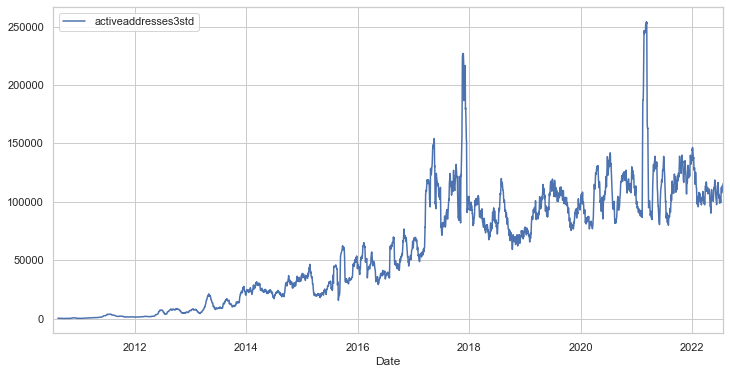

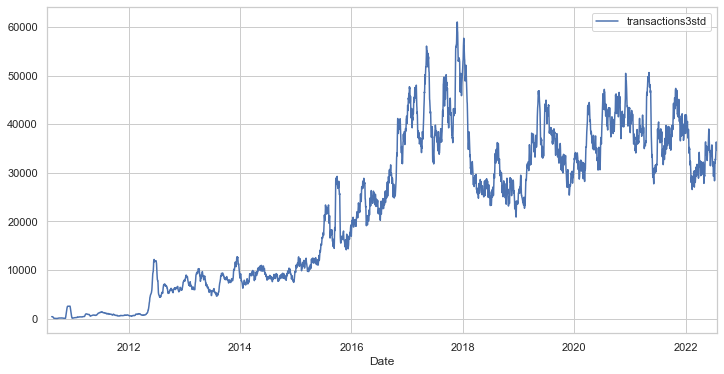

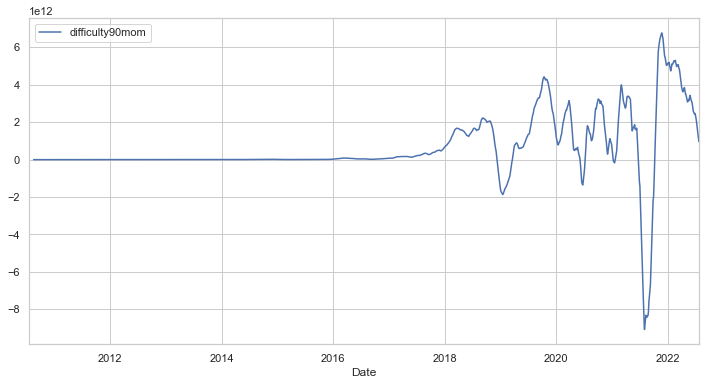

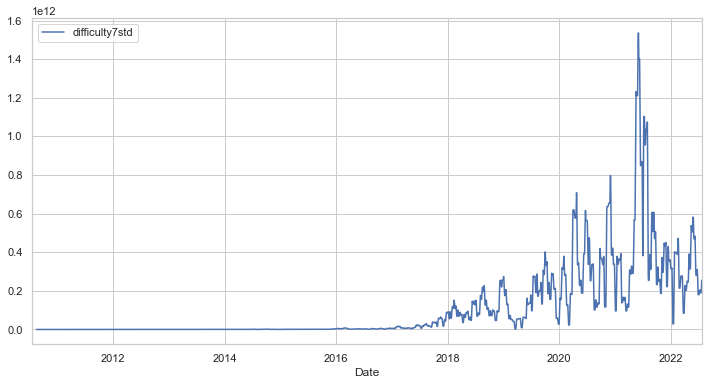

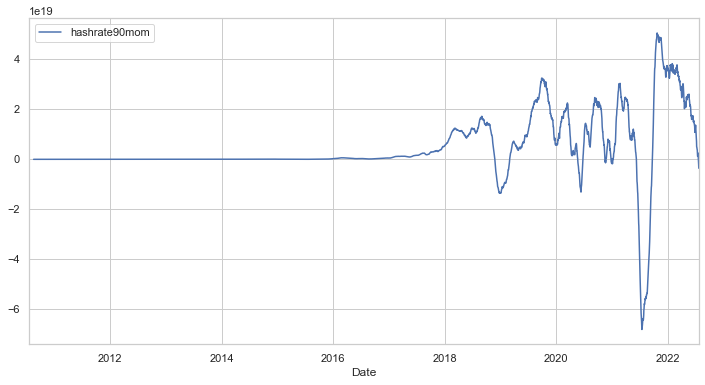

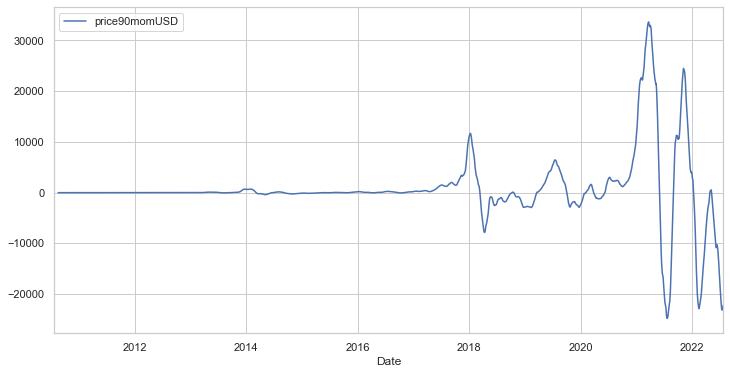

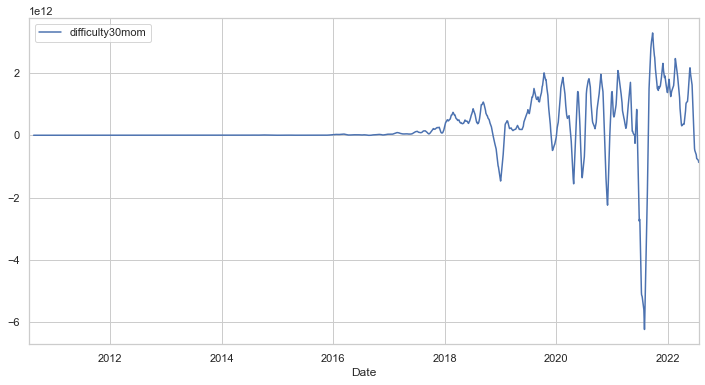

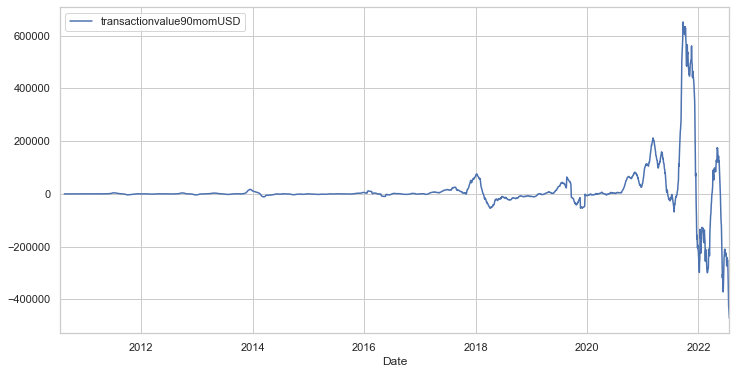

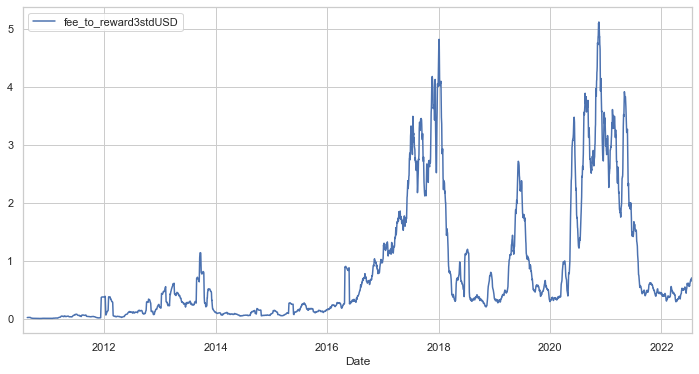

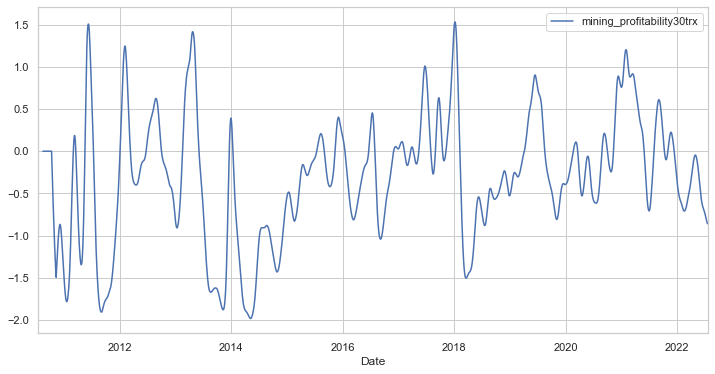

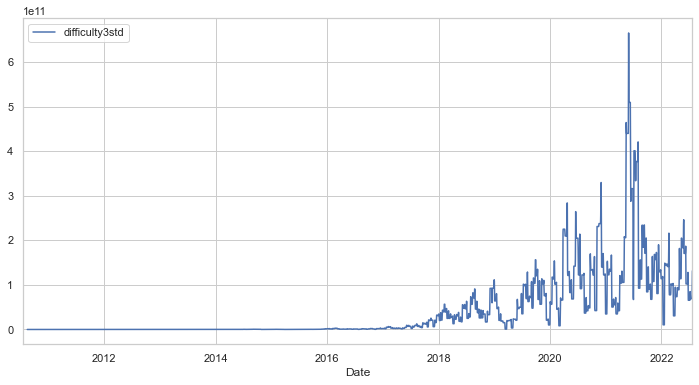

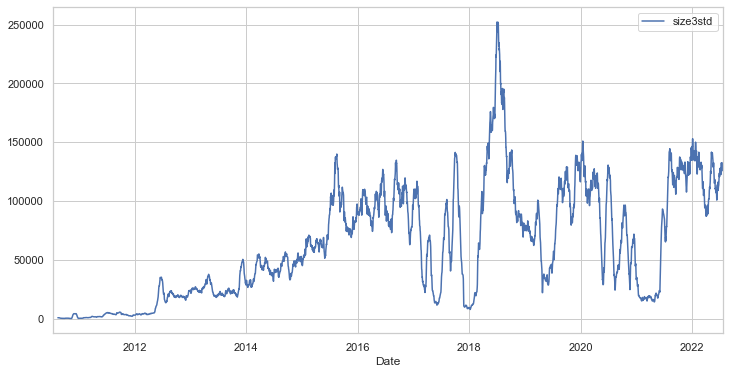

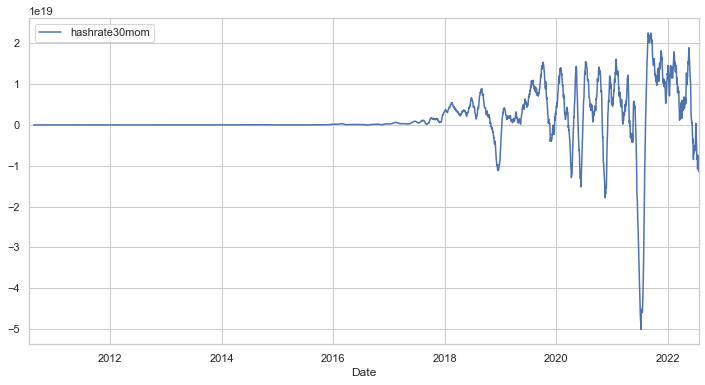

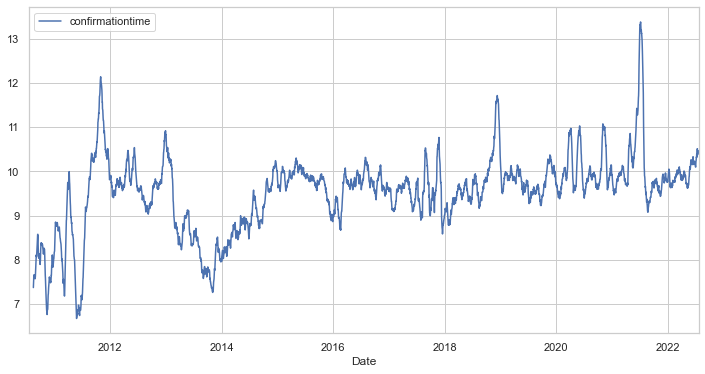

In [389]:
# Visulising the price of BTC 30 day average basis
features=list(X_train.columns)
for i in features:
    sns.set()
    sns.set_style('whitegrid')
    X_train[i].rolling(window=30).mean().plot(figsize=(12,6),label=i)
    plt.legend()
    plt.show()

In [390]:
# estimators=[]
# estimators.append(['minmax',MinMaxScaler(feature_range=(-1,1))])
# scale=Pipeline(estimators)
# X_min_max=scale.fit_transform(X_train2)
# y_min_max=scale.fit_transform(y)

In [391]:
# y_min_max

In [392]:
# from sklearn.decomposition import PCA
# pca = PCA(0.95).fit(X_min_max)

# plt.plot(np.cumsum(pca.explained_variance_ratio_)*100)
# plt.xlabel('number of components')
# plt.ylabel('cumulative variance %')
# plt.show()

In [393]:
# np.cumsum(pca.explained_variance_ratio_)

In [394]:
# pca.components_

# Next task is to select important features

# Features selection using Extra tree Regressor

In [395]:
#ref https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor
X_train, X_test, y_train, y_test = train_test_split(X_min_max, y, random_state=0)
y_train=np.ravel(y_train)
y_test=np.ravel(y_test)
clf = ExtraTreesRegressor(n_estimators=50, random_state=0).fit(X_train, y_train)
clf.score(X_test, y_test)

In [396]:
feature_importances=[]
for i in clf.feature_importances_:
    feature_importances.append('{:f}'.format(float(i)))

In [397]:
len(feature_importances)

In [398]:
count=0
sum=0
index=[]
for i in range(len(feature_importances)):
    if float(feature_importances[i])>=0.001299:
        #print(i," ",feature_importances[i])
        count+=1
        sum+=float(feature_importances[i])
        index.append(i)

In [399]:
index

In [400]:
len(index)

In [401]:
feature_=list(X.columns)
print("List of important features are: ",[feature_[i] for i in index],"\n")
print(sum*100,"%")
print("number of important features usind tree classifier \n",count)

# Top 20 feature using correlation method

In [402]:
print(top_20_features)

['Unnamed: 0', 'sentinusdUSD', 'transactionfeesUSD', 'difficulty14std', 'activeaddresses7std', 'mining_profitability90trx', 'activeaddresses3std', 'transactions3std', 'difficulty90mom', 'difficulty7std', 'hashrate90mom', 'price90momUSD', 'difficulty30mom', 'transactionvalue90momUSD', 'fee_to_reward3stdUSD', 'mining_profitability30trx', 'difficulty3std', 'size3std', 'hashrate30mom', 'confirmationtime']


In [403]:
def intersection(lst1, lst2):
    return list(set(lst1) & set(lst2))
print("common important features are")
imp_feature_=intersection(feature_, top_20_features)
print(imp_feature_)
print("Total imp features are",len(imp_feature_))

In [404]:
len(imp_feature_)

# Feature engineering

In [410]:
train_data_=df[["priceUSD",'sentinusd90momUSD', 'hashrate90mom', 'difficulty90mom', 'activeaddresses7std', 'difficulty7std', 'price14momUSD', 'sentinusdUSD', 'transactionvalue3stdUSD', 'activeaddresses3std', 'transactions3std', 'price30momUSD', 'fee_to_reward3stdUSD', 'mining_profitability90trx', 'sentinusd30momUSD', 'transactionvalue30momUSD', 'transactions', 'difficulty', 'difficulty14std', 'difficulty30mom', 'mining_profitability30trx']]


In [411]:
train_data_.shape

(4389, 20)

In [412]:
train_data_

,priceUSD,sentinusdUSD,transactionfeesUSD,difficulty14std,activeaddresses7std,mining_profitability90trx,activeaddresses3std,transactions3std,difficulty90mom,difficulty7std,hashrate90mom,price90momUSD,difficulty30mom,transactionvalue90momUSD,fee_to_reward3stdUSD,mining_profitability30trx,difficulty3std,size3std,hashrate30mom,confirmationtime
Date,,,,,,,,,,,,,,,,,,,,
2010-07-18,0.0726,2.612000e+03,0.000243,1.079720e+02,3836.000,0.000,806.213,409.788,1.737230e+02,1.275940e+02,1.467781e+09,0.0,1.641620e+02,0.0,0.000,0.000,1.123560e+02,191.448,1.426285e+09,8.372
2010-07-19,0.0859,4.047000e+03,0.000022,1.247640e+02,3872.000,0.000,139.870,106.596,1.737230e+02,1.338740e+02,1.466614e+09,0.0,1.641620e+02,0.0,0.014,0.000,0.000000e+00,104.932,1.417005e+09,8.276
2010-07-20,0.0783,2.341000e+03,0.000000,1.360760e+02,3973.000,0.000,57.743,136.532,1.735570e+02,1.295820e+02,1.553496e+09,0.0,1.641620e+02,0.0,0.015,0.000,0.000000e+00,211.366,1.500528e+09,7.956
2010-07-21,0.0767,2.122000e+03,0.000000,1.430260e+02,910.003,0.000,133.889,129.502,1.700790e+02,1.157030e+02,1.613749e+09,0.0,1.641620e+02,0.0,0.001,0.000,0.000000e+00,361.145,1.571638e+09,6.957
2010-07-22,0.0649,2.570000e+03,0.000000,1.462080e+02,652.409,0.000,256.262,166.984,1.700790e+02,8.340300e+01,1.621318e+09,0.0,1.641620e+02,0.0,0.000,0.000,0.000000e+00,442.707,1.572259e+09,8.182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-19,22514.0000,5.415818e+10,2.147000,2.148773e+11,194475.000,-0.432,216592.000,63833.000,9.268707e+11,3.852714e+06,-1.267260e+19,-18949.0,-1.130495e+12,-349377.0,0.832,-0.814,2.459129e+06,114218.000,-3.820002e+19,10.435
2022-07-20,23568.0000,4.309965e+10,2.324000,1.369287e+09,186298.000,-0.434,114188.000,26401.000,9.268707e+11,3.852714e+06,-3.853800e+19,-18138.0,-1.130495e+12,-574952.0,0.419,-0.794,2.459129e+06,69028.000,-1.108997e+19,11.429
2022-07-21,22936.0000,5.569455e+10,2.026000,1.677421e+11,178152.000,-0.436,94111.000,16533.000,6.012077e+11,2.279166e+11,-2.875793e+19,-17213.0,-1.456158e+12,-531027.0,0.369,-0.770,3.070380e+11,26310.000,-2.433603e+19,10.360


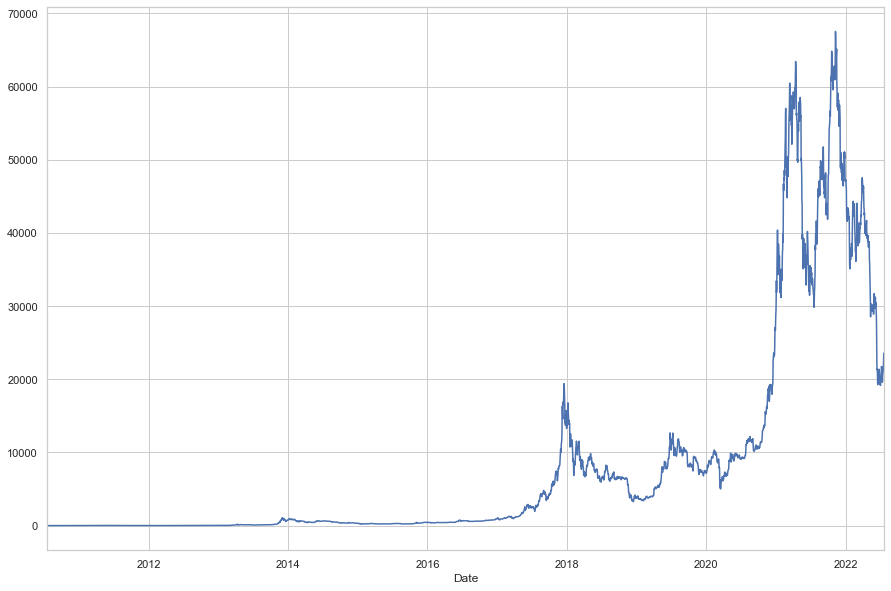

In [413]:
train_data_.sort_index()['2010':'2022']["priceUSD"].plot(subplots=True, figsize=(15,10))
plt.savefig('bitcoin.png')
plt.show()

# Percent change

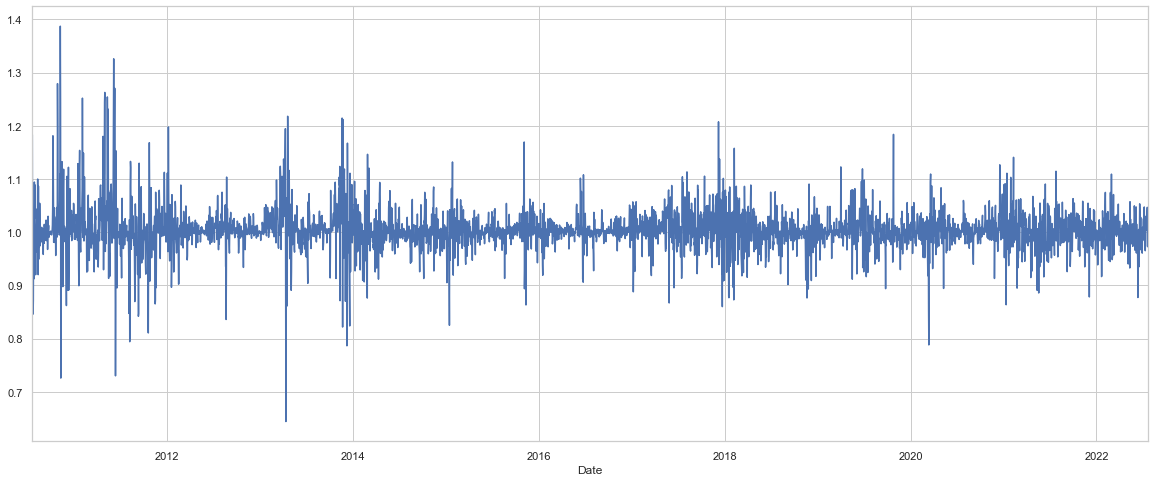

In [414]:
#train_data_['Change'] = train_data_.priceUSD.div(train_data_.priceUSD.shift())
train_data_ = train_data_.assign(Change=pd.Series(train_data_.priceUSD.div(train_data_.priceUSD.shift())))
train_data_['Change'].plot(figsize=(20,8))
plt.show()

# Expanding mean

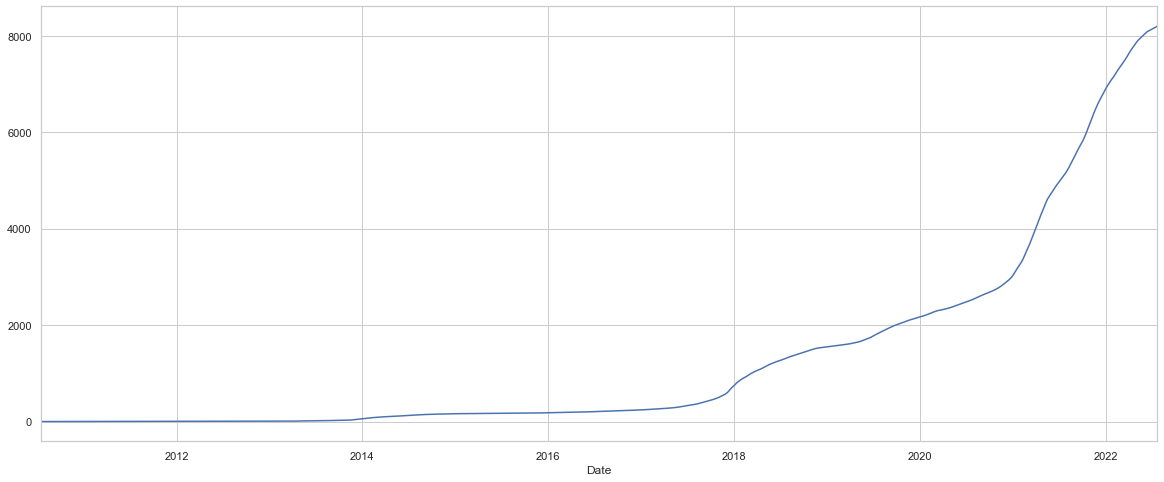

In [415]:
#train_data_['expanding_mean'] = train_data_['priceUSD'].expanding(1).mean()
train_data_ = train_data_.assign(expanding_mean=pd.Series(train_data_['priceUSD'].expanding(1).mean()))
train_data_['expanding_mean'].plot(figsize=(20,8))
plt.show()

# Lag feature

In [416]:
train_data_['lag_1'] = train_data_['priceUSD'].shift(1)
train_data_['lag_2'] = train_data_['priceUSD'].shift(2)
train_data_['lag_3'] = train_data_['priceUSD'].shift(3)
train_data_['lag_4'] = train_data_['priceUSD'].shift(4)
train_data_['lag_5'] = train_data_['priceUSD'].shift(5)
train_data_['lag_6'] = train_data_['priceUSD'].shift(6)
train_data_['lag_7'] = train_data_['priceUSD'].shift(7)

In [417]:
train_data_

,priceUSD,sentinusdUSD,transactionfeesUSD,difficulty14std,activeaddresses7std,mining_profitability90trx,activeaddresses3std,transactions3std,difficulty90mom,difficulty7std,...,confirmationtime,Change,expanding_mean,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
Date,,,,,,,,,,,,,,,,,,,,,
2010-07-18,0.0726,2.612000e+03,0.000243,1.079720e+02,3836.000,0.000,806.213,409.788,1.737230e+02,1.275940e+02,...,8.372,NaN,0.072600,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-19,0.0859,4.047000e+03,0.000022,1.247640e+02,3872.000,0.000,139.870,106.596,1.737230e+02,1.338740e+02,...,8.276,1.183196,0.079250,0.0726,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-20,0.0783,2.341000e+03,0.000000,1.360760e+02,3973.000,0.000,57.743,136.532,1.735570e+02,1.295820e+02,...,7.956,0.911525,0.078933,0.0859,0.0726,NaN,NaN,NaN,NaN,NaN
2010-07-21,0.0767,2.122000e+03,0.000000,1.430260e+02,910.003,0.000,133.889,129.502,1.700790e+02,1.157030e+02,...,6.957,0.979566,0.078375,0.0783,0.0859,0.0726,NaN,NaN,NaN,NaN
2010-07-22,0.0649,2.570000e+03,0.000000,1.462080e+02,652.409,0.000,256.262,166.984,1.700790e+02,8.340300e+01,...,8.182,0.846154,0.075680,0.0767,0.0783,0.0859,0.0726,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-19,22514.0000,5.415818e+10,2.147000,2.148773e+11,194475.000,-0.432,216592.000,63833.000,9.268707e+11,3.852714e+06,...,10.435,1.032468,8184.452909,21806.0000,21223.0000,20866.0000,20781.0000,20173.0,19603.0,19759.0
2022-07-20,23568.0000,4.309965e+10,2.324000,1.369287e+09,186298.000,-0.434,114188.000,26401.000,9.268707e+11,3.852714e+06,...,11.429,1.046815,8187.960330,22514.0000,21806.0000,21223.0000,20866.0000,20781.0,20173.0,19603.0
2022-07-21,22936.0000,5.569455e+10,2.026000,1.677421e+11,178152.000,-0.436,94111.000,16533.000,6.012077e+11,2.279166e+11,...,10.360,0.973184,8191.322089,23568.0000,22514.0000,21806.0000,21223.0000,20866.0,20781.0,20173.0


# Return

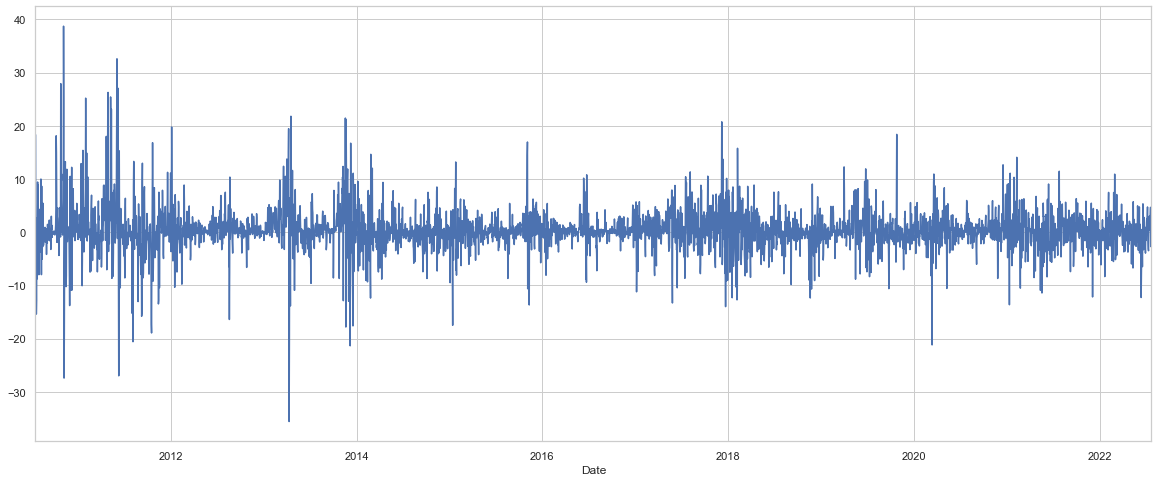

In [418]:
train_data_ = train_data_.assign(Return=pd.Series(train_data_.Change.sub(1).mul(100)))
train_data_['Return'].plot(figsize=(20,8))
plt.show()

In [419]:
train_data_.shape

(4389, 30)

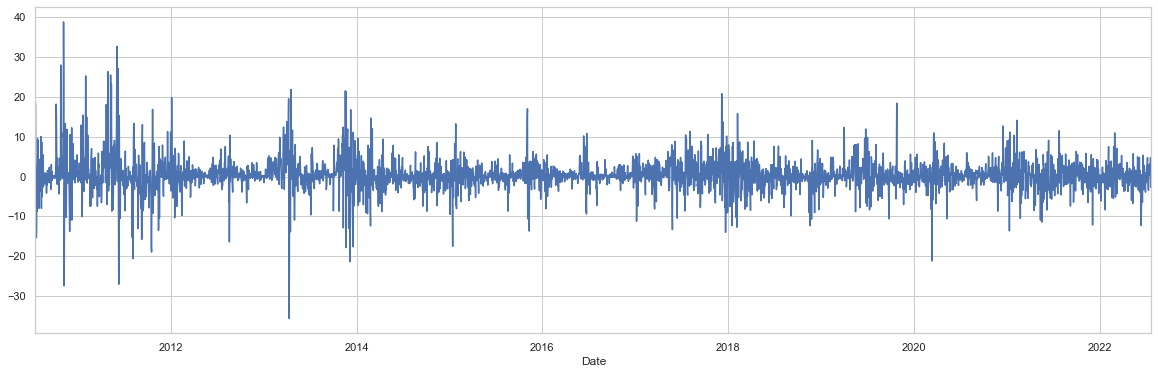

In [420]:
train_data_.priceUSD.pct_change().mul(100).plot(figsize=(20,6))
plt.show()

# Window functions

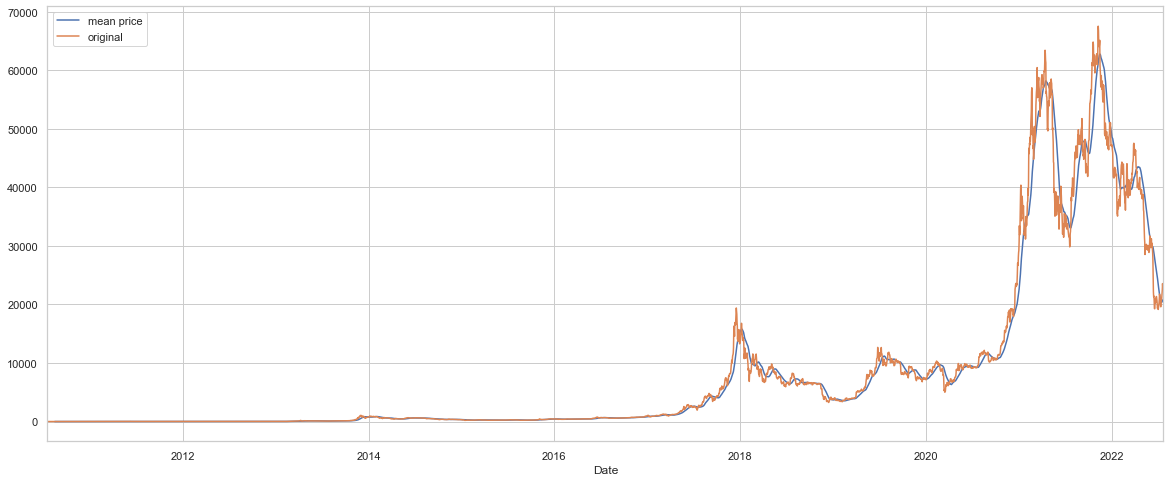

In [421]:
train_data_ = train_data_.assign(Mean=pd.Series(train_data_['priceUSD'].rolling(window=30).mean()))
train_data_['Mean'].plot(figsize=(20,8),label='mean price')
train_data_['priceUSD'].plot(label='original')
plt.legend()
plt.show()

# Time series decomposition and Random walks

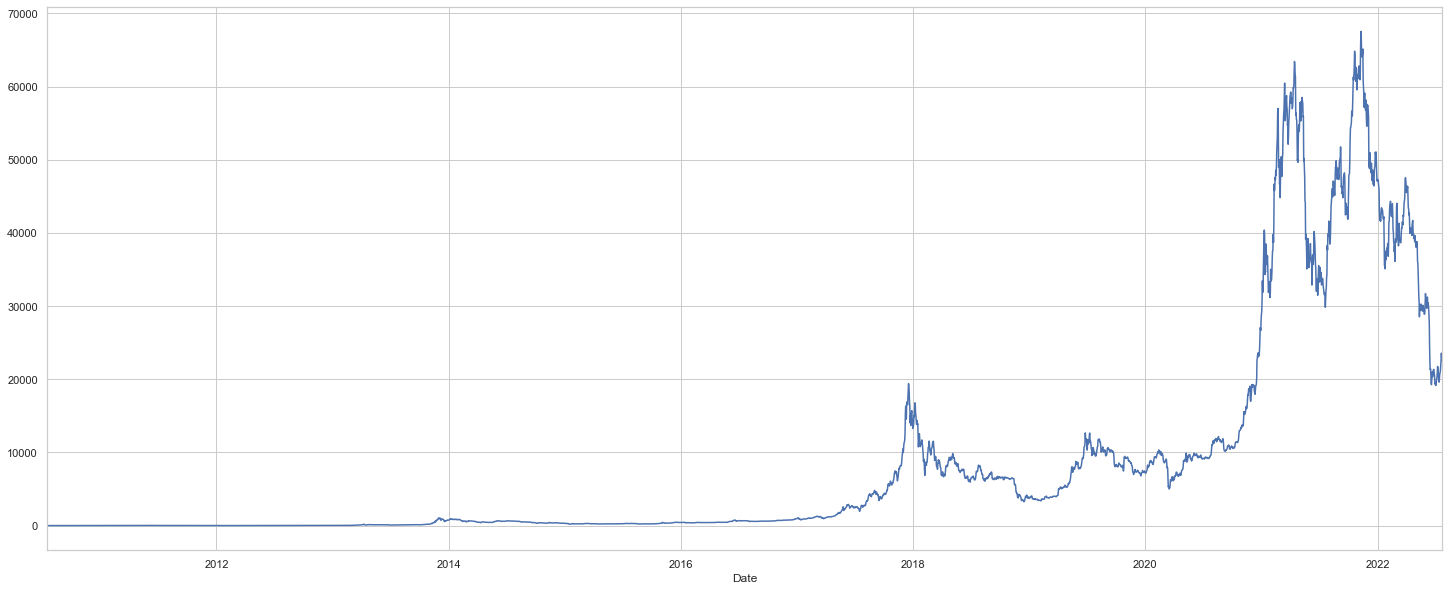

In [422]:
train_data_["priceUSD"].plot(figsize=(25,10))
plt.show()

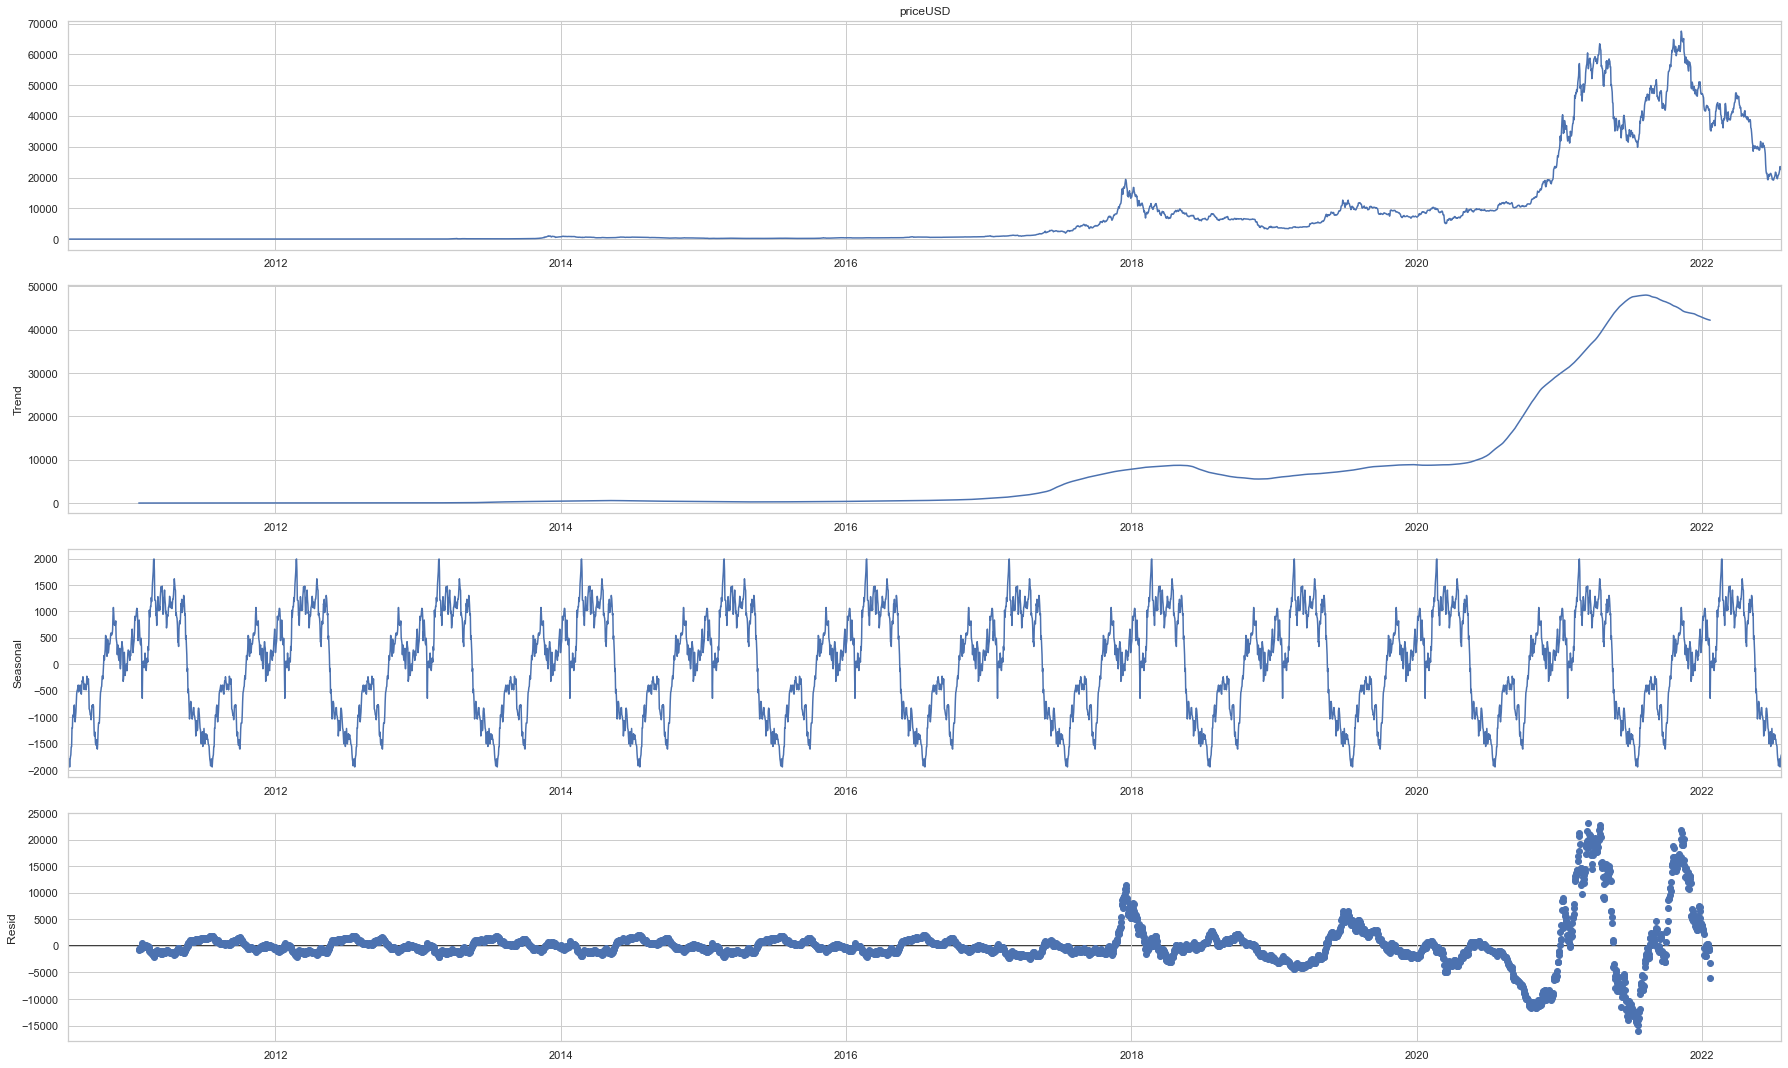

In [423]:
# Now, for decomposition...
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 25, 15
decomposed_train_data_ = sm.tsa.seasonal_decompose(train_data_["priceUSD"],period=365) # The frequncy is annual
figure = decomposed_train_data_.plot()
plt.show()

In [424]:
train_data_.isnull().values.any()

True

In [425]:
train_data_.dropna(axis = 0, how ='any',inplace=True)
train_data_.isnull().values.any()

False

In [426]:
train_data_["priceUSD"].describe()

count     4360.000000
mean      8252.519528
std      14625.003704
min          0.059900
25%        119.383000
50%        673.850000
75%       8778.500000
max      67547.000000
Name: priceUSD, dtype: float64

In [427]:
train_data_.shape

(4360, 31)

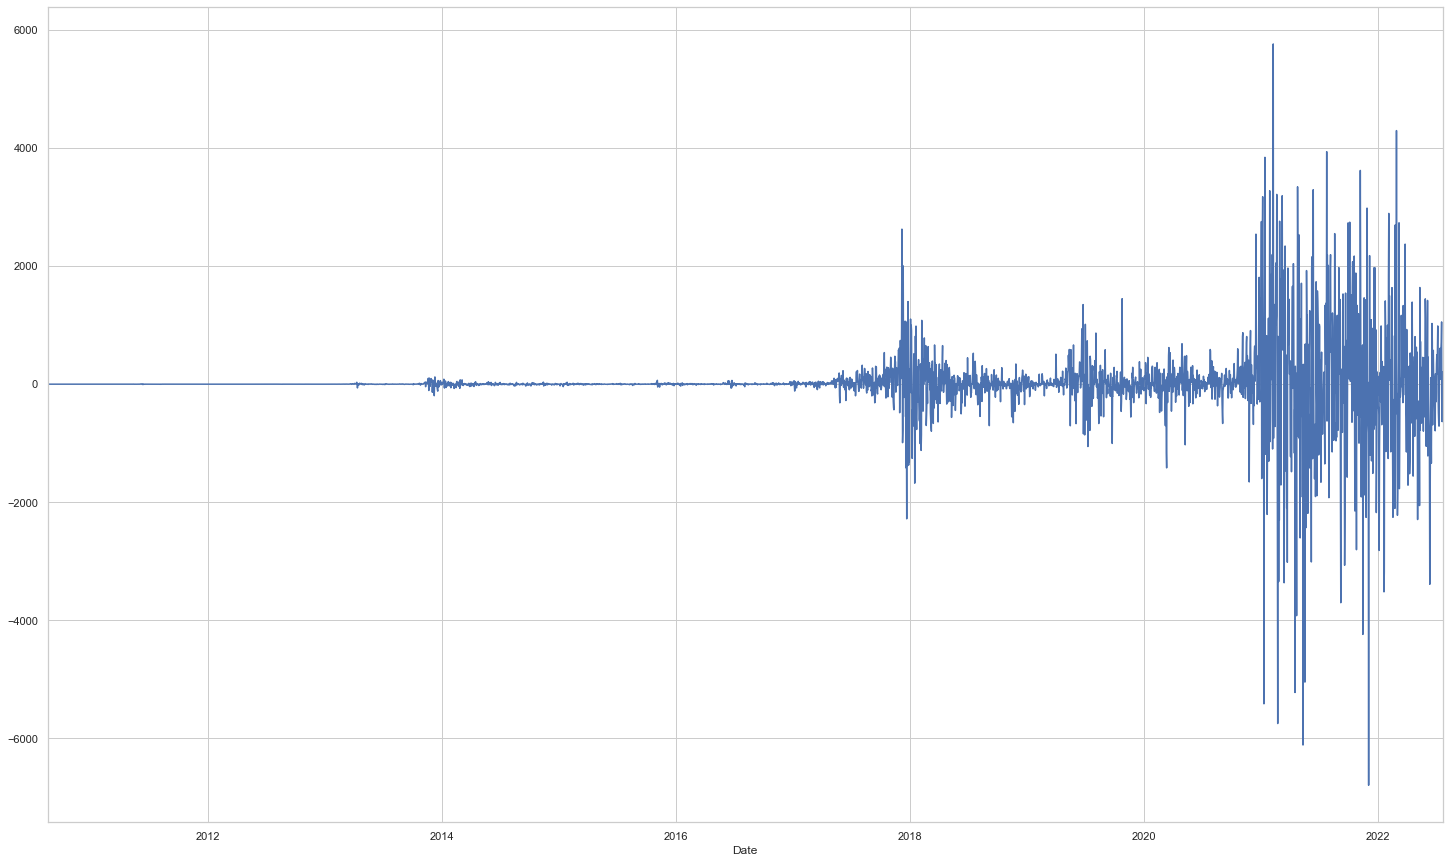

In [428]:
diff_Y_i = train_data_["priceUSD"].diff()
train_data_ = train_data_.assign(difference=pd.Series(diff_Y_i))

#drop the NAN in the first row
diff_Y_i = diff_Y_i.dropna()
diff_Y_i.plot()
plt.show()

# Modelling using statstools

# autoregressive (AR) mode

# Forecasting a simulated model

In [429]:
print(train_data_.isnull().values.sum())
train_data_.dropna(axis = 0, how ='any',inplace=True)
print(train_data_.isnull().values.sum())

1
0


In [430]:
train_data_.shape

(4359, 32)

In [431]:
# prepare situation
def moving_average_(data):
    X = data
    window = 3
    history = [X[i] for i in range(window)]
    test = [X[i] for i in range(window, len(X))]
    predictions = list()
    # walk forward over time steps in test
    for t in range(len(test)):
        length = len(history)
        yhat = mean([history[i] for i in range(length-window,length)])
        obs = test[t]
        predictions.append(yhat)
        history.append(obs)
        #print('predicted=%f, expected=%f' % (yhat, obs))
    error = mean_squared_error(test, predictions)
    print('Test MSE: %.3f' % error)
    # zoom plot
    pyplot.plot(test[0:100],label="Original")
    pyplot.plot(predictions[0:100], color='red',label="Prediction")
    plt.legend()
    pyplot.show()

Test MSE: 559300.239


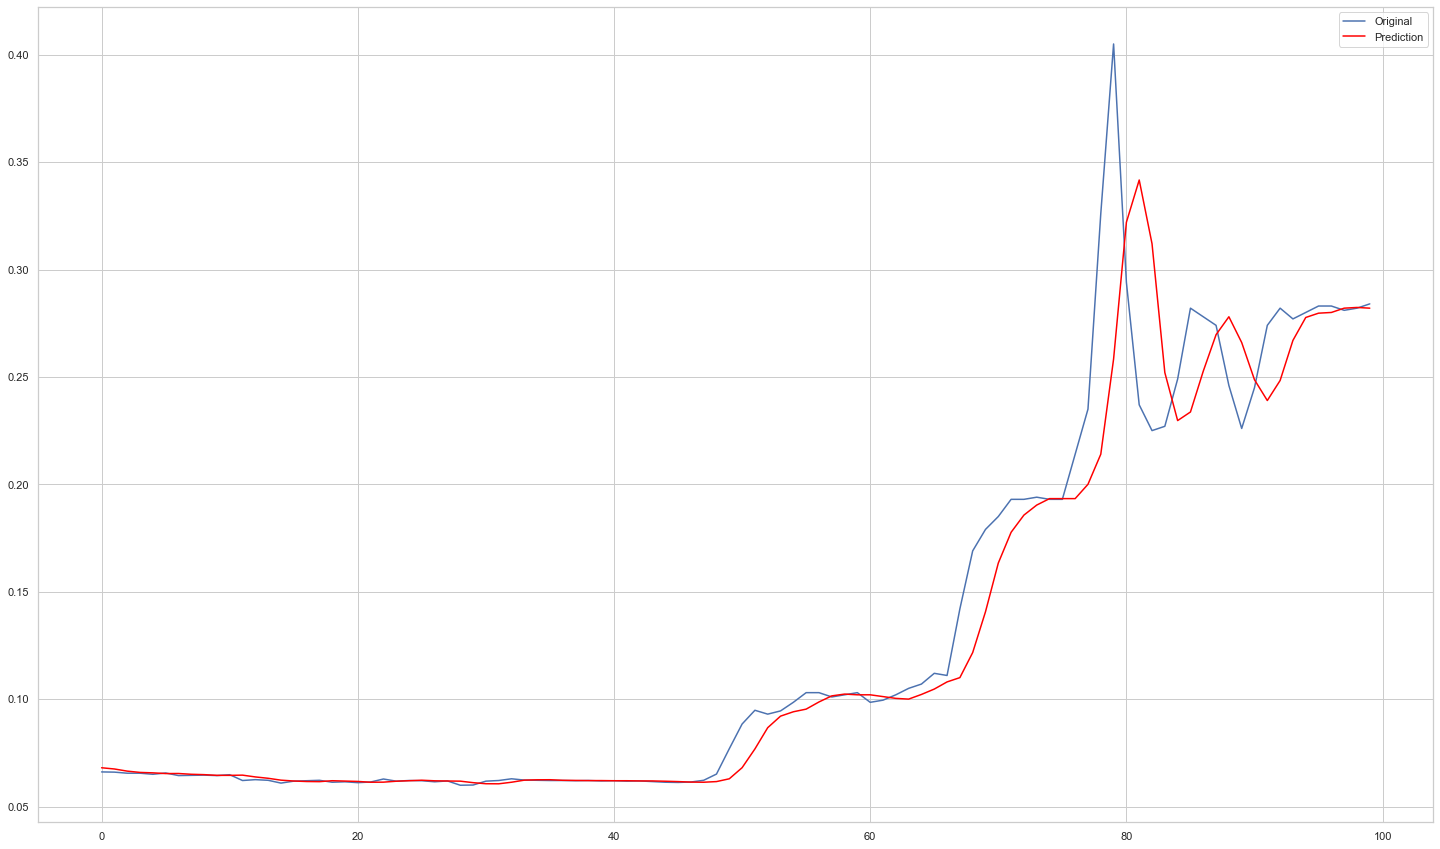

In [432]:
moving_average_(train_data_["priceUSD"].values)

In [433]:
df_train = train_data_[train_data_.index < "2019"]
df_valid = train_data_[train_data_.index >= "2019"]

In [434]:
def exponential_moving_():
    weights = np.arange(1,31) #this creates an array with integers 1 to 31 included
    weights
    wma10 = train_data_["priceUSD"].rolling(30).apply(lambda prices: np.dot(prices, weights)/weights.sum(), raw=True)
    train_data_['30day_WMA'] = np.round(wma10, decimals=3)
    #sma10 = train_data_['priceUSD'].rolling(30).mean()
    temp = train_data_.dropna(how='any',axis=0) 
    print(sqrt(mean_squared_error(temp.priceUSD, temp['30day_WMA'])))
    plt.figure(figsize = (12,6))
    plt.plot(train_data_['priceUSD'], label="Price")
    plt.plot(wma10, label="30-Day WMA")
    #plt.plot(sma10, label="10-Day SMA")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

1574.291085255173


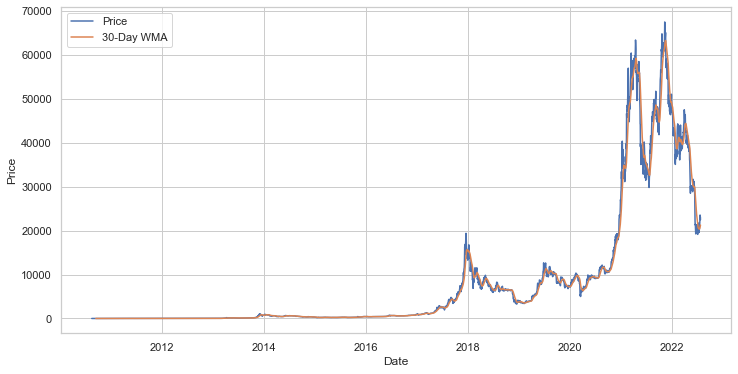

In [435]:
exponential_moving_()

# Exponential Moving Average

In [436]:
def exponential_moving_average():
    ema30 = train_data_['priceUSD'].ewm(span=30).mean()
    train_data_['30_day_EMA'] = np.round(ema30, decimals=3)
    print(sqrt(mean_squared_error(train_data_.priceUSD, train_data_['30_day_EMA'])))
    plt.figure(figsize = (12,6))
    plt.plot(train_data_['priceUSD'], label="Price")
    plt.plot(ema30, label="30-Day WMA")
    #plt.plot(sma10, label="10-Day SMA")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

1815.1562463416376


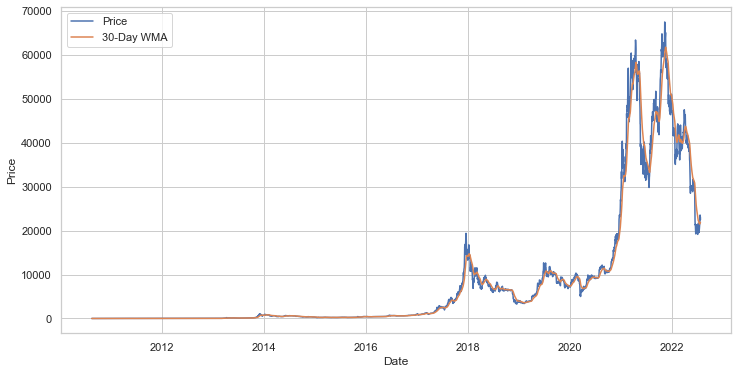

In [437]:
exponential_moving_average()

In [438]:
"""
from pandas import read_csv
from numpy import mean
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
# prepare situation
X = train_data_["priceUSD"].values
window = 3
history = [X[i] for i in range(window)]
test = [X[i] for i in range(window, len(X))]
predictions = list()
# walk forward over time steps in test
for t in range(len(test)):
	length = len(history)
	yhat = mean([history[i] for i in range(length-window,length)])
	obs = test[t]
	predictions.append(yhat)
	history.append(obs)
	#print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# zoom plot
pyplot.plot(test[0:100],label="Original")
pyplot.plot(predictions[0:100], color='red',label="Prediction")
plt.legend()
pyplot.show()
"""

'\nfrom pandas import read_csv\nfrom numpy import mean\nfrom sklearn.metrics import mean_squared_error\nfrom matplotlib import pyplot\n# prepare situation\nX = train_data_["priceUSD"].values\nwindow = 3\nhistory = [X[i] for i in range(window)]\ntest = [X[i] for i in range(window, len(X))]\npredictions = list()\n# walk forward over time steps in test\nfor t in range(len(test)):\n\tlength = len(history)\n\tyhat = mean([history[i] for i in range(length-window,length)])\n\tobs = test[t]\n\tpredictions.append(yhat)\n\thistory.append(obs)\n\t#print(\'predicted=%f, expected=%f\' % (yhat, obs))\nerror = mean_squared_error(test, predictions)\nprint(\'Test MSE: %.3f\' % error)\n# zoom plot\npyplot.plot(test[0:100],label="Original")\npyplot.plot(predictions[0:100], color=\'red\',label="Prediction")\nplt.legend()\npyplot.show()\n'

# Prediction using ARIMA model

In [439]:
#train_data_.columns
train_data_.fillna(method='ffill', inplace=True)
train_data_.fillna(method='backfill', inplace=True)

In [440]:
train_data_.isnull().values.any()

False

In [441]:
#train_data_.columns

In [442]:
df_train = train_data_[train_data_.index < "2019"]
df_valid = train_data_[train_data_.index >= "2019"]

In [443]:
imp_feature_

['Unnamed: 0',
 'sentinusdUSD',
 'transactionfeesUSD',
 'difficulty14std',
 'activeaddresses7std',
 'mining_profitability90trx',
 'activeaddresses3std',
 'transactions3std',
 'difficulty90mom',
 'difficulty7std',
 'hashrate90mom',
 'price90momUSD',
 'difficulty30mom',
 'transactionvalue90momUSD',
 'fee_to_reward3stdUSD',
 'mining_profitability30trx',
 'difficulty3std',
 'size3std',
 'hashrate30mom',
 'confirmationtime']

In [445]:
important_feature_=['sentinusd90momUSD','hashrate90mom','difficulty90mom',
                    'activeaddresses7std', 'difficulty7std','price14momUSD',
                    'sentinusdUSD', 'transactionvalue3stdUSD','activeaddresses3std',
                    'transactions3std', 'price30momUSD','fee_to_reward3stdUSD',
                    'mining_profitability90trx','sentinusd30momUSD',
                    'transactionvalue30momUSD', 'transactions','difficulty',
                    'difficulty14std', 'difficulty30mom', 'mining_profitability30trx',
                    'Change','expanding_mean','lag_1','lag_2','lag_3','lag_4','lag_5',
                    'lag_6','lag_7','Return','Mean','difference','30day_WMA','30_day_EMA']

In [446]:
len(important_feature_)

33

In [447]:
!pip install pmdarima

In [448]:
from pmdarima import auto_arima
model = auto_arima(df_train.priceUSD, exogenous=df_train[important_feature_], trace=True, error_action="ignore", suppress_warnings=True)
model.fit(df_train.priceUSD, exogenous=df_train[important_feature_])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=39618.090, Time=6.86 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=39691.826, Time=5.21 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=39619.738, Time=5.33 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=39624.194, Time=5.84 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=61175.067, Time=4.86 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=39617.283, Time=5.96 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=39619.626, Time=5.89 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=39621.334, Time=5.54 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=39616.598, Time=6.89 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=39619.188, Time=6.70 sec


c:\Users\ahcha\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1899: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
c:\Users\ahcha\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=39703.607, Time=6.93 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=39621.726, Time=7.70 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=39620.263, Time=7.31 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=39622.978, Time=7.92 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=39614.755, Time=6.69 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=39617.344, Time=6.38 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=39615.425, Time=5.73 sec


c:\Users\ahcha\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1899: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
c:\Users\ahcha\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,1,3)(0,0,0)[0]             : AIC=39701.812, Time=6.75 sec
 ARIMA(1,1,4)(0,0,0)[0]             : AIC=39619.869, Time=7.46 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=39617.773, Time=5.87 sec
 ARIMA(0,1,4)(0,0,0)[0]             : AIC=39618.413, Time=7.40 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=39616.227, Time=5.94 sec
 ARIMA(2,1,4)(0,0,0)[0]             : AIC=39613.324, Time=7.50 sec
 ARIMA(3,1,4)(0,0,0)[0]             : AIC=39608.248, Time=7.57 sec


c:\Users\ahcha\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1899: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
c:\Users\ahcha\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(3,1,3)(0,0,0)[0]             : AIC=39703.858, Time=6.92 sec
 ARIMA(4,1,4)(0,0,0)[0]             : AIC=39614.414, Time=7.86 sec
 ARIMA(3,1,5)(0,0,0)[0]             : AIC=39619.548, Time=8.96 sec
 ARIMA(2,1,5)(0,0,0)[0]             : AIC=39623.327, Time=9.02 sec


c:\Users\ahcha\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1899: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
c:\Users\ahcha\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(4,1,3)(0,0,0)[0]             : AIC=39705.907, Time=7.46 sec
 ARIMA(4,1,5)(0,0,0)[0]             : AIC=39619.399, Time=9.63 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=39610.201, Time=8.22 sec

Best model:  ARIMA(3,1,4)(0,0,0)[0]          
Total fit time: 214.374 seconds


ARIMA(order=(3, 1, 4), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [449]:
forecast = model.predict(n_periods=len(df_valid), exogenous=df_valid[important_feature_])
df_valid = df_valid.assign(Forecast_ARIMAX=forecast)
#df_valid["Forecast_ARIMAX"] = forecast

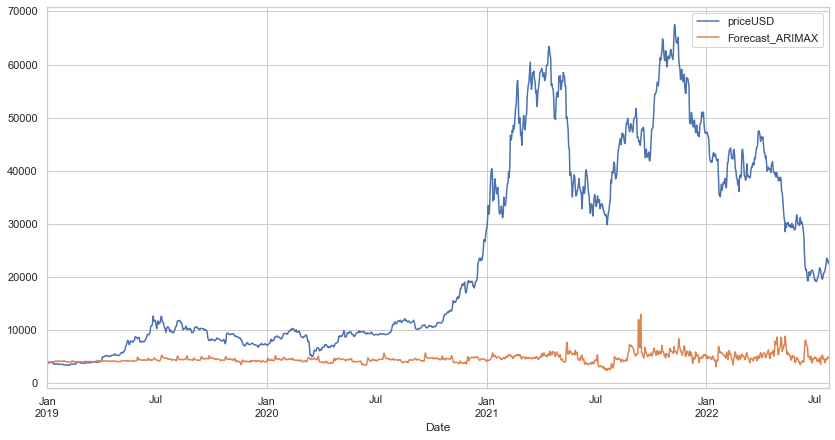

In [450]:
df_valid[["priceUSD", "Forecast_ARIMAX"]].plot(figsize=(14, 7))
plt.show()

In [451]:
print("RMSE of Auto ARIMAX:", np.sqrt(mean_squared_error(df_valid.priceUSD, df_valid.Forecast_ARIMAX)))
print("\nMAE of Auto ARIMAX:", mean_absolute_error(df_valid.priceUSD, df_valid.Forecast_ARIMAX))

RMSE of Auto ARIMAX: 26466.56152387841

MAE of Auto ARIMAX: 19350.423881721734


In [452]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3059 entries, 2010-08-17 to 2018-12-31
Data columns (total 34 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   priceUSD                   3059 non-null   float64
 1   sentinusdUSD               3059 non-null   float64
 2   transactionfeesUSD         3059 non-null   float64
 3   difficulty14std            3059 non-null   float64
 4   activeaddresses7std        3059 non-null   float64
 5   mining_profitability90trx  3059 non-null   float64
 6   activeaddresses3std        3059 non-null   float64
 7   transactions3std           3059 non-null   float64
 8   difficulty90mom            3059 non-null   float64
 9   difficulty7std             3059 non-null   float64
 10  hashrate90mom              3059 non-null   float64
 11  price90momUSD              3059 non-null   float64
 12  difficulty30mom            3059 non-null   float64
 13  transactionvalue90momUSD   305